# ZRE Projekt - 2023
#### Honza Černocký a Honza Pavlus, FIT VUT Brno, 2023
#### ` Celkem bodů 29`
---

Principem projektu oprava signálů narušených klipováním pomocí lineární predikce nebo jiných technik. Nachystali jsme 100 signálů z TIMITu tak, že máte k disposici originál i klipovanou verzi. Klipovaná verze simuluje ztrátu nejvyššího bitu. Signály a seznam viz https://www.fit.vutbr.cz/study/courses/ZRE/public/2022-23/. 

Projekt doporučujeme řešit v Pythonu v Google Colab, ale je možné použít i jiný jazyk / prostředí, v tomto případě prosím zašlete protokol a zdrojáky emailem.  

---



In [36]:
# nacteni signalu a listu, at to nemusite hledat
import os

if not os.path.exists('proj_zre_2023.tgz'):
    !wget https://www.fit.vutbr.cz/study/courses/ZRE/public/2022-23/proj_zre_2023.tgz
    !tar xfz proj_zre_2023.tgz
!ls

# make graphs interactive
!pip install mpld3
%matplotlib inline
import scipy
#import mpld3
#mpld3.enable_notebook()

clipped_signals        list_students.txt  proj_zre_2023.tgz    venv
kitic13declipping.pdf  orig_signals	  RBAR_icassp2015.pdf  zreprojekt.ipynb

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Úloha 1 - Detektor klipovaných signálů - `2 body `

Navrhněte a naprogramujte detektor klipovaných částí signálu. Pozor, klipované mohou být jak kladné, tak záporné vzorky. Zobrazte několik příkladů těchto klipovaných částí v časové a ve frekvenční oblasti (spektrogram). 

---

Klipované části detekuji pomocí hledání vzorků, které mají absolutní hodnotu >= maximu amplitudy signálu. Výsledkem je pole indexů klipovaných vzorků z funkce `detect_clipped`.

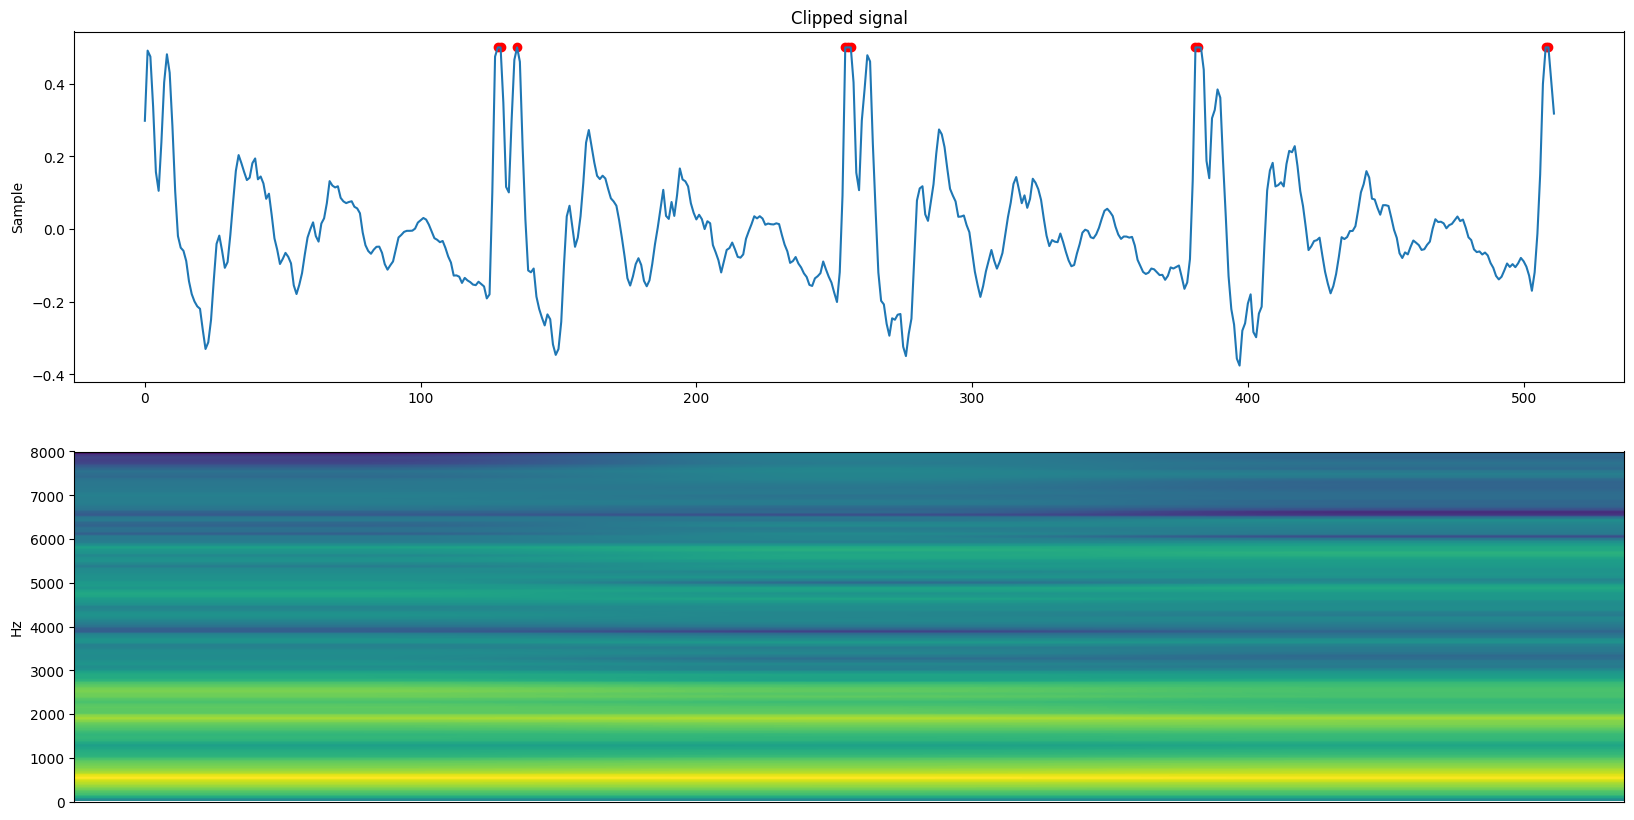

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

Fs = 16000
# load all files from directory
def load_dir(path):
    folder, _, files = next(os.walk(path))
    signals, srs = zip(*[librosa.load(os.path.join(folder, f),sr=None) for f in files])
    assert all(np.array(srs) == Fs)
    #remove mean
    return tuple(np.array(s - np.mean(np.array(s))) for s in signals)

# try to detect threshold and return indices of clipped samples
def detect_clipped(signal):
    mx = np.max(signal)
    return np.array(np.where(np.abs(signal) >= mx))

# plot example of clipped frame with its spectrogram
def plot_clipped(signal, clipped_indices, spectr=False, title=None):
    # try to find part where clipping is "most" visible
    frame_len = 512
    mid = np.median(clipped_indices).astype(int)
    # get frame around mid
    src = signal[mid-frame_len//2:mid+frame_len//2]
    clipped_src = clipped_indices - mid
    clipped_i = np.where(np.abs(clipped_src) < frame_len//2)[1]
    clipped_src = clipped_src[0][clipped_i] + frame_len//2

    # plot frame and it's spectrogram
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    plt.title(title)
    plt.plot(src)
    plt.scatter(clipped_src, src[clipped_src], c='r')
    plt.gca().axes.get_yaxis().set_label_text('Sample')
    if spectr:
        plt.subplot(2, 1, 2)
        plt.specgram(src, Fs=Fs)
        plt.gca().axes.get_xaxis().set_visible(False)
        plt.gca().axes.get_yaxis().set_label_text('Hz')
    plt.show()


signals_clp = load_dir('clipped_signals')
signals_orig = load_dir('orig_signals')

show_example1, show_example2 = 0, 25

test_file_clp = signals_clp[show_example1]
clipped = detect_clipped(test_file_clp)
clipp_threshold = np.max(test_file_clp)
plot_clipped(test_file_clp, clipped, spectr=True, title="Clipped signal")

## Úloha 2 - Výpočet SNR - `2 body `

Napište funkci pro výpočet poměru signálu k šumu, kde šum (jmenovatel) bude chyba (rozdíl mezi klipovaným signálem a originálem) a signál (čitatel) je originální signál. Spočítejte SNR způsobené klipováním pro všech 100 signálů. Berte je v úvahu celé, nejen klipované části.

---

### Vaše řešení:

$ SNR = 10 \cdot \log_{10} \left( \frac{\sum_{i=1}^{N} x_i^2}{\sum_{i=1}^{N} (x_i - y_i)^2} \right) $


Standardní vzorec pro výpočet SNR, kde $x_i$ je originální vzorek a $y_i$ je klipovaný vzorek. SNR je limitováno na 100dB pro zamezení NaN.

In [38]:
def snr(orig, modified):
    snr = 10 * np.log10(np.sum(orig**2) / np.sum((orig - modified)**2))
    return np.min([snr, 100])

test_file_orig = signals_orig[show_example1]
print("sample SNR:", snr(test_file_orig, test_file_clp), "dB")
print("sample SNR:", snr(signals_orig[show_example2], signals_clp[show_example2]), "dB")



sample SNR: 29.11029815673828 dB
sample SNR: 28.257901668548584 dB


## Úloha 3 - Oprava pomocí predikce zleva - ` 5 bodů`

Napište funkci, která bude opravovat klipované části. Měla by pracovat tak, že na L=240 vzorcích signálu před klipovanou částí odhadne koeficienty prediktoru a ten využije k náhradě klipovaných vzorků predikcí z minulosti. Vyberte 2 opravené segmenty a zobrazte je. Připravte dvě promluvy k přehrání (pokud budete pracovat v Py notebooku, přímo v něm, pokud v něčem jiném, jako několik WAV souborů). Vyzkoušejte délky prediktoru od P=2 do P=20. Pro každou délku vyhodnoťte na všech 100 signálech SNR a spočítejte redukci SNR oproti původnímu stavu (SNRR - v procentech). 

---


### Vaše řešení:

Pro výpočet LPC koeficientů využívám knihovnu librosa. Predikci pak provádím IIR filtrem.

In [58]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format


def lpc(signal, ordr):
    #r = np.correlate(signal,signal, mode='full')
    #r = r[len(r)//2:len(r)//2 + ordr + 1]
    #a = np.linalg.inv(scipy.linalg.toeplitz(r[:-2])) @ -r[1:-1]
    a = librosa.lpc(signal, order=ordr-1)[1:]
    return a,np.hstack([1.0, -a])

# repair clipped signal using LPC
def fix_LPC(signal, p=20, l=240):
    clips = detect_clipped(signal)
    repaired = signal.copy()
    for i in clips[0]:
        if i+l > len(repaired):
            break
        a,b = lpc(repaired[i - l:i], p)
        repaired[i] = scipy.signal.lfilter(-a, [1.0], repaired[i - l:i])[-1]
    return repaired


#todo lower step when done
sample_density = 25 # calculate only each Xth sample
param_step,param_min,param_max = 9,2,20

# create empty pandas table
PDheaders = [('clip','foo'),
             [('left',x) for x in range(param_min, param_max + 1,param_step)],
             [('right',x) for x in range(param_min, param_max + 1,param_step)],
             [('combined',x) for x in range(param_min, param_max + 1,param_step)],
             ('IHT', 'foo')]
PDheaders_fix = []
for header in PDheaders:
    if type(header) == tuple:
        PDheaders_fix.append(header)
    else:
        PDheaders_fix += header
header = pd.MultiIndex.from_tuples(PDheaders_fix, names=['method', 'P'])
table = pd.DataFrame(columns=header)

#populate table with Nan
new_data = pd.DataFrame([[np.nan]*header.size], range(len(signals_clp)), header)
table = pd.concat([table, new_data], ignore_index=True)

#add original signal to table (for clip foo)
for i in range(len(signals_orig)):
    table.loc[i, ('clip', 'foo')] = snr(signals_orig[i], signals_clp[i])


signals_leftLPC = []
for i in range(0,len(signals_orig),sample_density):
    clp,orig = signals_clp[i], signals_orig[i]
    for p in range(param_min, param_max + 1,param_step):
        repr = fix_LPC(clp, p)
        table.loc[i, ('left', p)] = snr(orig,repr)
        if i in [show_example1, show_example2] and p == param_max:
            signals_leftLPC.append(repr)


for p in range(param_min, param_max + 1,param_step):
    table[('left', str(p) + " snrr %")] = table[('left', p)] / table[('clip', 'foo')] * 100
table

method  clip  left             right           combined            IHT   
P        foo     2    11    20     2   11   20        2   11   20  foo   
0      29.11 16.60 19.33 19.04   NaN  NaN  NaN      NaN  NaN  NaN  NaN  \
1      29.13   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
2      27.67   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
3      31.34   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
4      27.12   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
..       ...   ...   ...   ...   ...  ...  ...      ...  ...  ...  ...   
95     28.37   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
96     28.65   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
97     26.45   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
98     31.06   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   
99     29.57   NaN   NaN   NaN   NaN  NaN  NaN      NaN  NaN  NaN  NaN   

method     left                      
P      2 snrr % 11 snrr % 20 snrr %  
0         57.03     66.39     65.40  
1           NaN       NaN       NaN  
2           NaN       NaN       NaN  
3           NaN       NaN       NaN  
4           NaN       NaN       NaN  
..          ...       ...       ...  
95          NaN       NaN       NaN  
96          NaN       NaN       NaN  
97          NaN       NaN       NaN  
98          NaN       NaN       NaN  
99          NaN       NaN       NaN  

[100 rows x 14 columns]

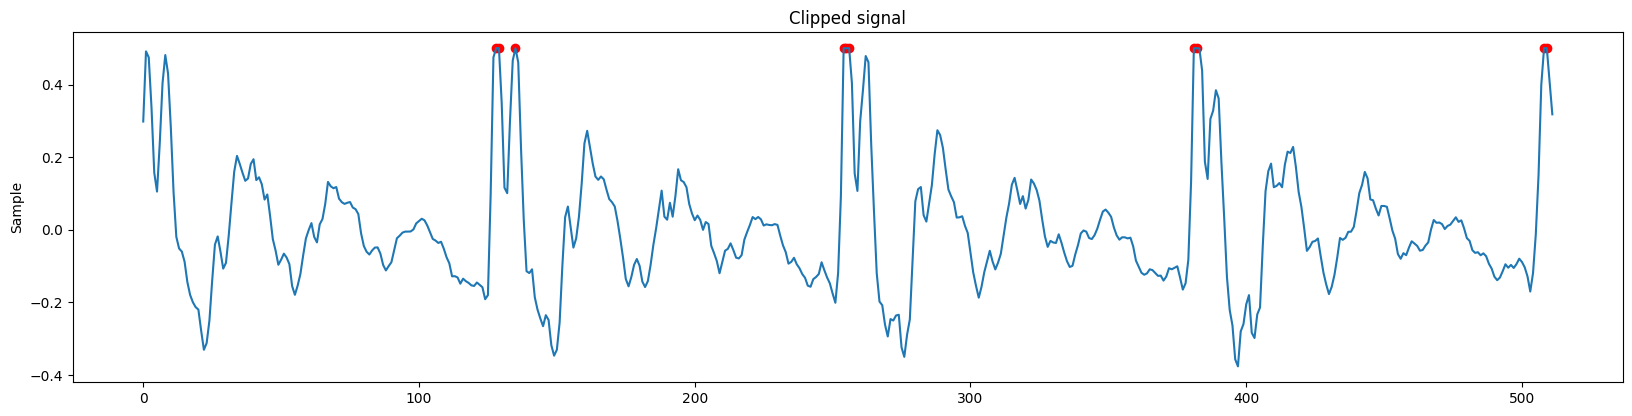

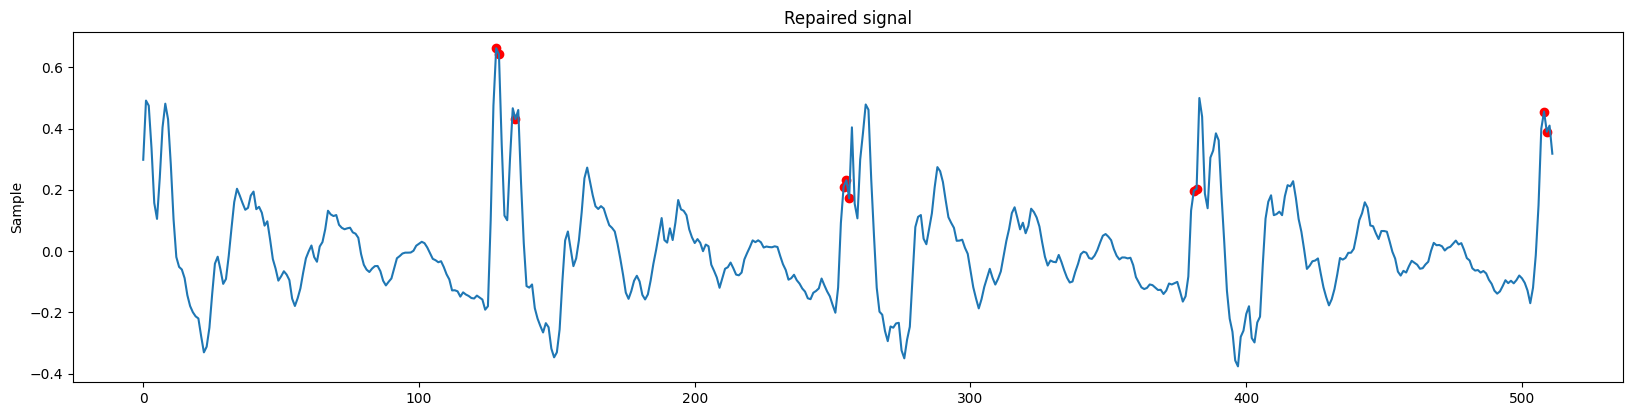

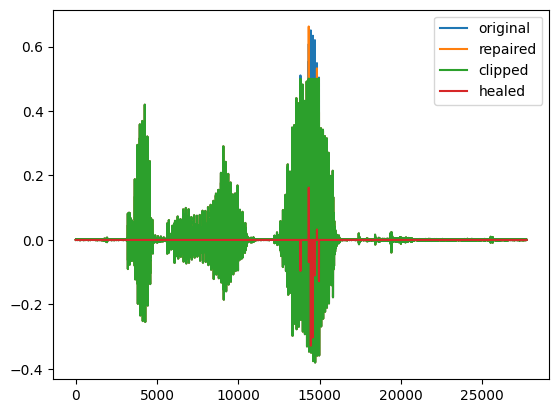

In [40]:
from IPython.display import Audio

def view_result(repaired, clip, orig):
    clipped = detect_clipped(clip)
    plot_clipped(clip, clipped, title="Clipped signal")
    plot_clipped(repaired, clipped,title="Repaired signal")

    fix, ax = plt.subplots()
    ax.plot(orig, label="original")
    ax.plot(repaired, label="repaired")
    ax.plot(clip, label="clipped")
    ax.plot(repaired - clip, label="healed")
    ax.legend()
    plt.show()

view_result(signals_leftLPC[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_leftLPC[0], rate=Fs)

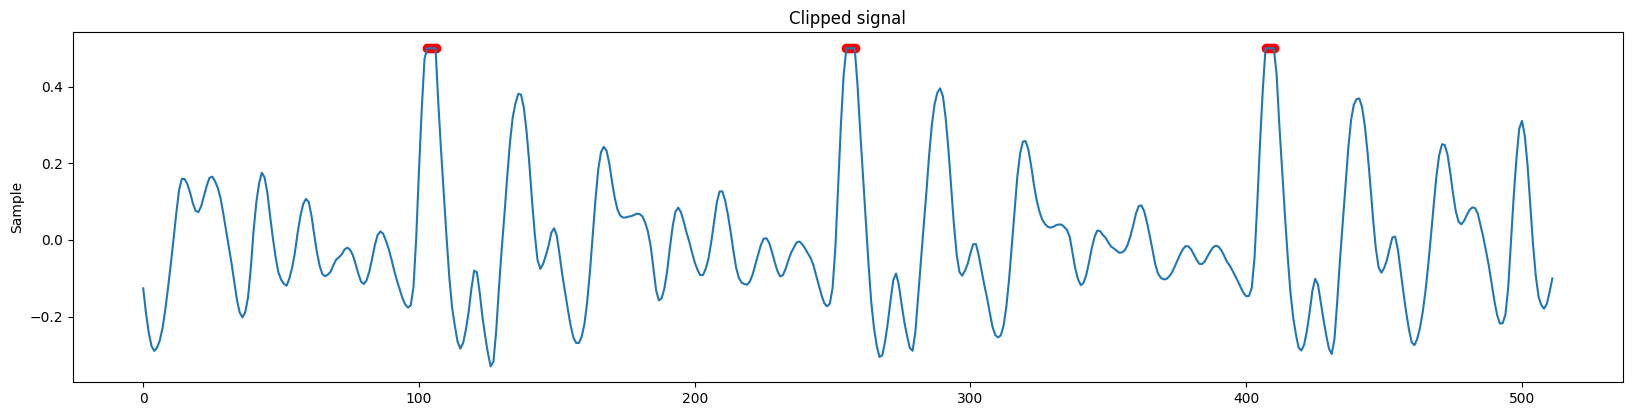

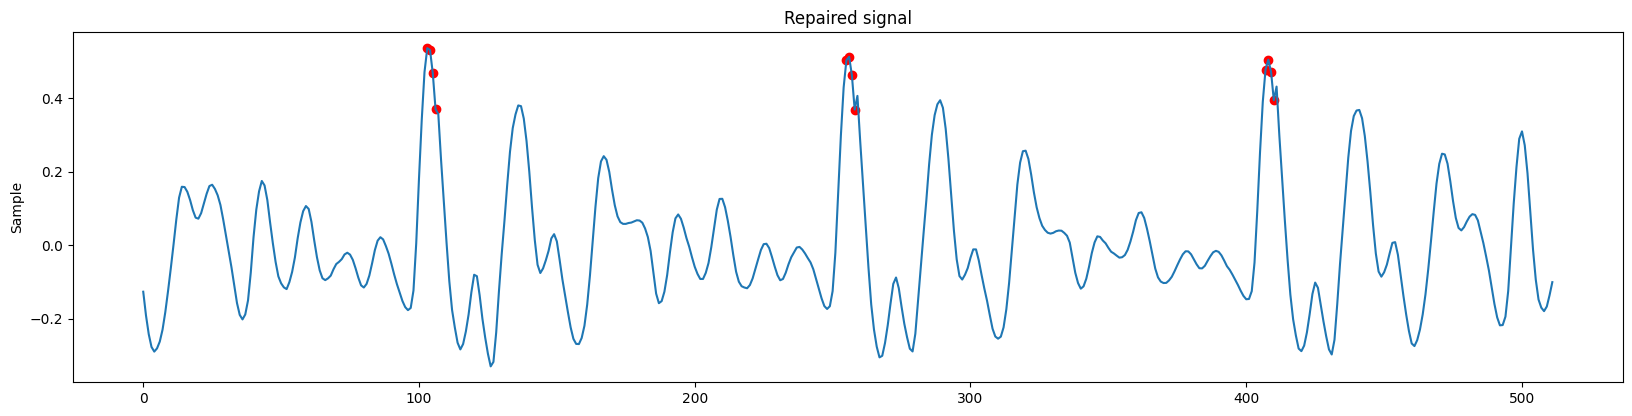

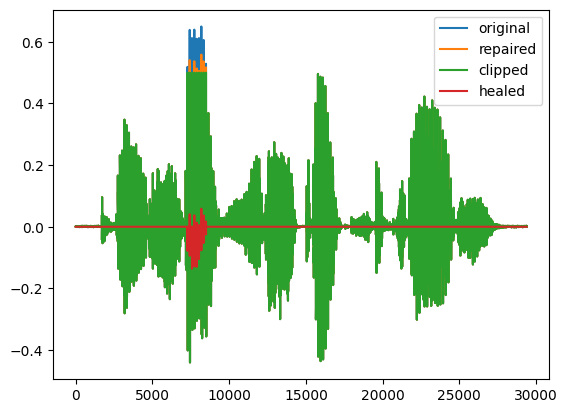

In [41]:
view_result(signals_leftLPC[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_leftLPC[1], rate=Fs)

## Úloha 4 - Oprava pomocí predikce zprava - ` 4 body`

Zopakujte předchozí cvičení, ale tentokrát predikujte klipované vzorky zprava (tedy z budoucnosti). Ve výpočtech budete tedy muset obracet signály nebo použít nekauzální filtry. Udělejte to samé, co v minulé cvičení, tedy vzorky k zobrazení a poslechu, závislost SNR a SNRR na délce prediktoru.

### Vaše řešení:

Predikce zprava probíha pouhým invertováním signálu.

In [59]:
# invert signal and predict
signals_rightLPC = []
for i in range(0,len(signals_orig),sample_density):
    clp,orig = signals_clp[i], signals_orig[i]
    clp,orig = clp[::-1], orig[::-1]
    for p in range(param_min, param_max + 1,param_step):
        repr = fix_LPC(clp, p)
        table.loc[i, ('right', p)] = snr(orig,repr)
        if i in [show_example1, show_example2] and p == param_max:
            signals_rightLPC.append(repr[::-1])



for p in range(param_min, param_max + 1,param_step):
    table[('right', str(p) + " snrr %")] = table[('right', p)] / table[('clip', 'foo')] * 100
table

method  clip  left             right             combined            IHT   
P        foo     2    11    20     2    11    20        2   11   20  foo   
0      29.11 16.60 19.33 19.04 20.84 30.64 31.04      NaN  NaN  NaN  NaN  \
1      29.13   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
2      27.67   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
3      31.34   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
4      27.12   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
..       ...   ...   ...   ...   ...   ...   ...      ...  ...  ...  ...   
95     28.37   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
96     28.65   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
97     26.45   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
98     31.06   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   
99     29.57   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN  NaN   

method     left                        right                      
P      2 snrr % 11 snrr % 20 snrr % 2 snrr % 11 snrr % 20 snrr %  
0         57.03     66.39     65.40    71.60    105.27    106.62  
1           NaN       NaN       NaN      NaN       NaN       NaN  
2           NaN       NaN       NaN      NaN       NaN       NaN  
3           NaN       NaN       NaN      NaN       NaN       NaN  
4           NaN       NaN       NaN      NaN       NaN       NaN  
..          ...       ...       ...      ...       ...       ...  
95          NaN       NaN       NaN      NaN       NaN       NaN  
96          NaN       NaN       NaN      NaN       NaN       NaN  
97          NaN       NaN       NaN      NaN       NaN       NaN  
98          NaN       NaN       NaN      NaN       NaN       NaN  
99          NaN       NaN       NaN      NaN       NaN       NaN  

[100 rows x 17 columns]

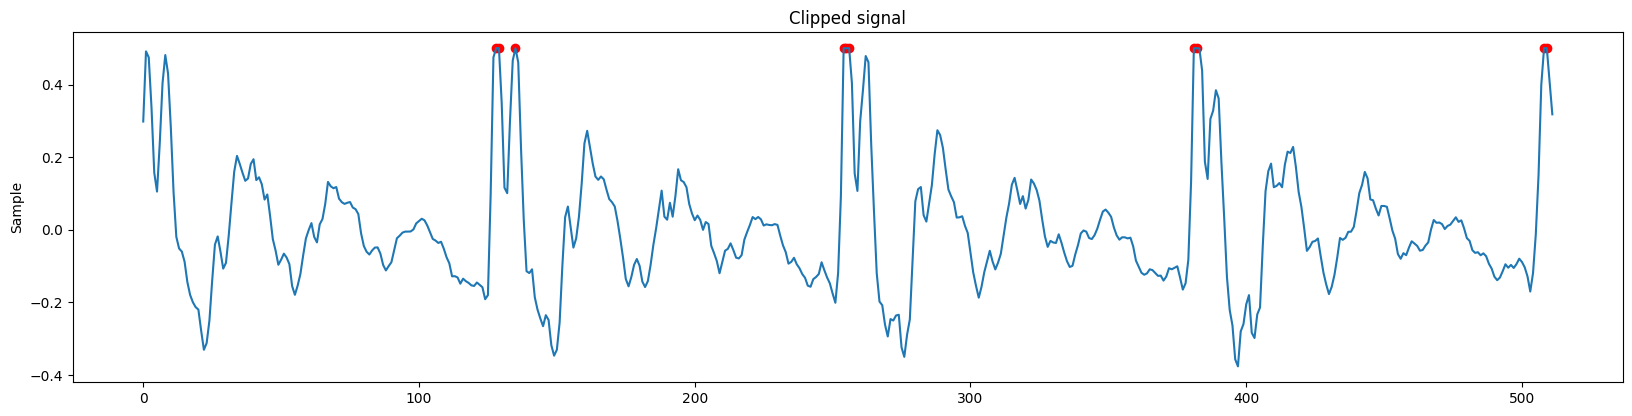

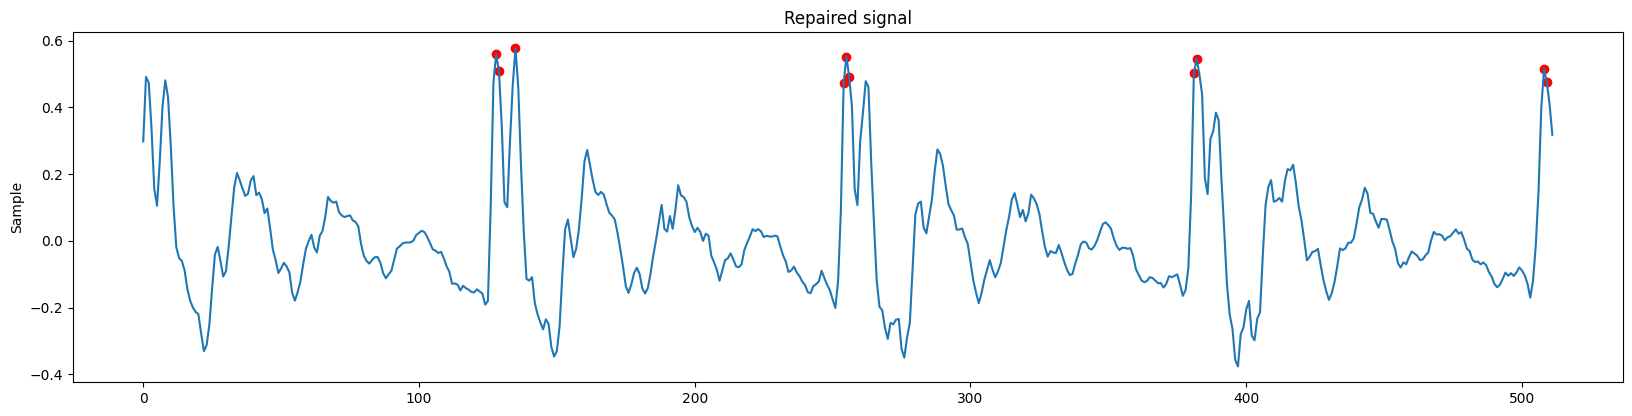

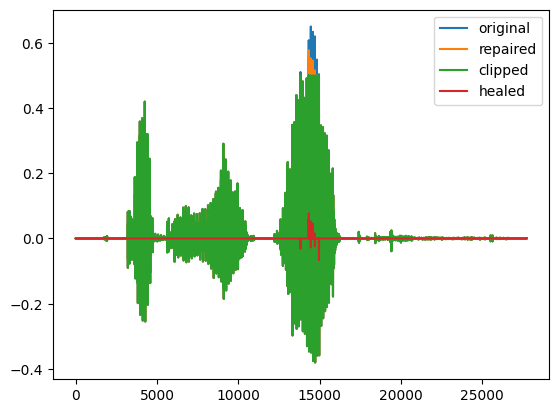

In [43]:
view_result(signals_rightLPC[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_rightLPC[0], rate=Fs)

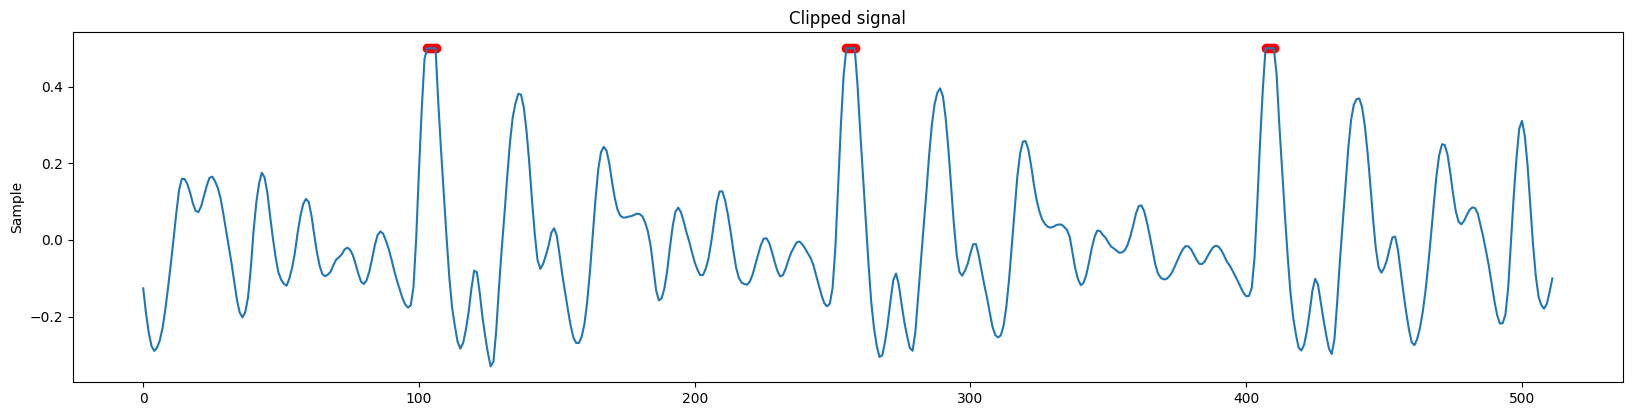

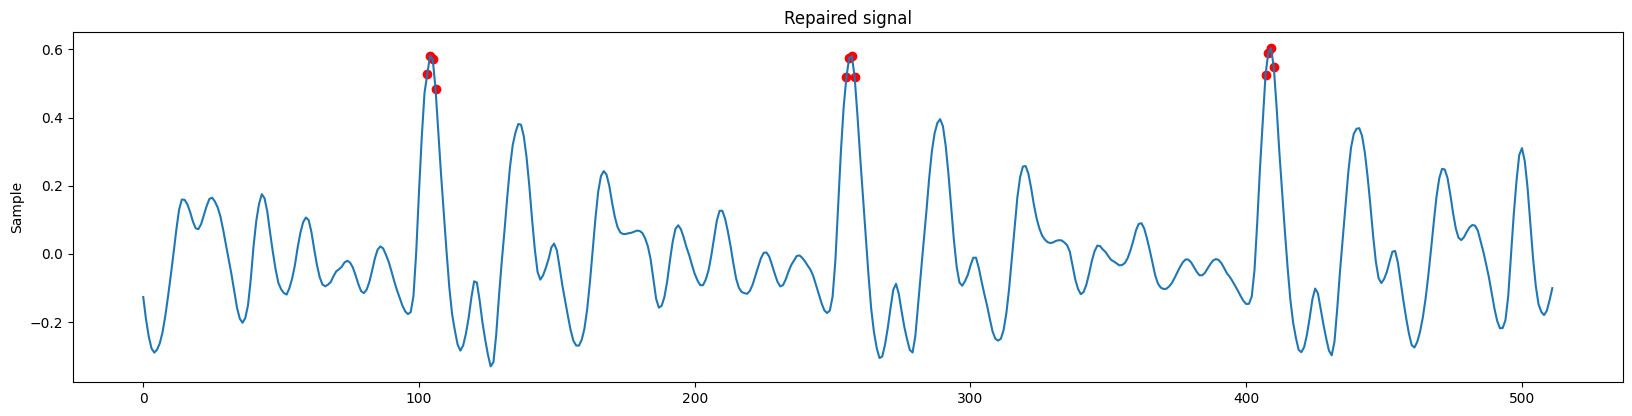

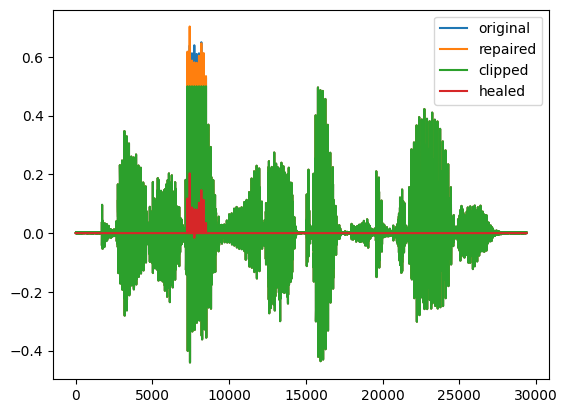

In [44]:
view_result(signals_rightLPC[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_rightLPC[1], rate=Fs)

## Úloha 5 - Lineární kombinace obou predikcí - ` 4 body`

Pro klipované vzorky proveďte lineární kombinaci obou predikcí, můžete vyzkoušet různé interpolace (s konstantními váhami 0,5 a 0,5, s klesajícím oknem zleva a stoupajícím zprava, cokoliv jiného). Proveďte opět ty samé kroky jako v minulých cvičeních, tedy vzorky k zobrazení a poslechu, závislost SNR a SNRR na délce prediktoru. 

---


### Vaše řešení:

V tomto podúkolu jsem použil prostou lineární kombinaci obou predikcí s váhou 0.5.

In [45]:
weight = 0.5
signals_combinedLPC = []
for i in range(0,len(signals_orig),sample_density):
    clp,orig = signals_clp[i], signals_orig[i]
    clp_rev,orig_rev = clp[::-1], orig[::-1]
    for p in range(param_min, param_max + 1,param_step):
        repr = fix_LPC(clp, p)
        repr_rev = fix_LPC(clp_rev, p)[::-1]
        combined_repr = repr * weight + repr_rev * (1-weight)
        table.loc[i, ('combined', p)] = snr(orig,combined_repr)
        if i in [show_example1, show_example2] and p == param_max:
            signals_combinedLPC.append(combined_repr)


for p in range(param_min, param_max + 1,param_step):
    table[('combined', str(p) + " snrr %")] = table[('combined', p)] / table[('clip', 'foo')] * 100

table

method  clip  left             right             combined              IHT   
P        foo     2    11    20     2    11    20        2    11    20  foo   
0      29.11 16.60 19.33 19.04 20.84 30.64 31.04    18.77 23.77 23.43  NaN  \
1      29.13   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
2      27.67   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
3      31.34   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
4      27.12   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
..       ...   ...   ...   ...   ...   ...   ...      ...   ...   ...  ...   
95     28.37   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
96     28.65   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
97     26.45   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
98     31.06   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   
99     29.57   NaN   NaN   NaN   NaN   NaN   NaN      NaN   NaN   NaN  NaN   

method     left                        right                     combined   
P      2 snrr % 11 snrr % 20 snrr % 2 snrr % 11 snrr % 20 snrr % 2 snrr %   
0         57.03     66.39     65.40    71.60    105.27    106.62    64.48  \
1           NaN       NaN       NaN      NaN       NaN       NaN      NaN   
2           NaN       NaN       NaN      NaN       NaN       NaN      NaN   
3           NaN       NaN       NaN      NaN       NaN       NaN      NaN   
4           NaN       NaN       NaN      NaN       NaN       NaN      NaN   
..          ...       ...       ...      ...       ...       ...      ...   
95          NaN       NaN       NaN      NaN       NaN       NaN      NaN   
96          NaN       NaN       NaN      NaN       NaN       NaN      NaN   
97          NaN       NaN       NaN      NaN       NaN       NaN      NaN   
98          NaN       NaN       NaN      NaN       NaN       NaN      NaN   
99          NaN       NaN       NaN      NaN       NaN       NaN      NaN   

method                      
P      11 snrr % 20 snrr %  
0          81.66     80.48  
1            NaN       NaN  
2            NaN       NaN  
3            NaN       NaN  
4            NaN       NaN  
..           ...       ...  
95           NaN       NaN  
96           NaN       NaN  
97           NaN       NaN  
98           NaN       NaN  
99           NaN       NaN  

[100 rows x 20 columns]

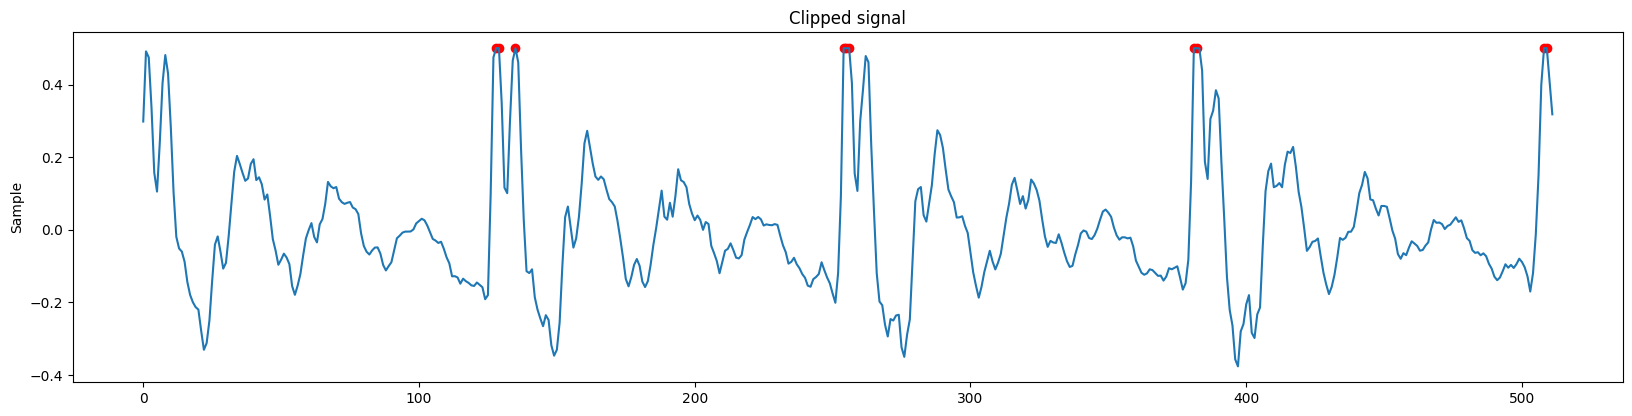

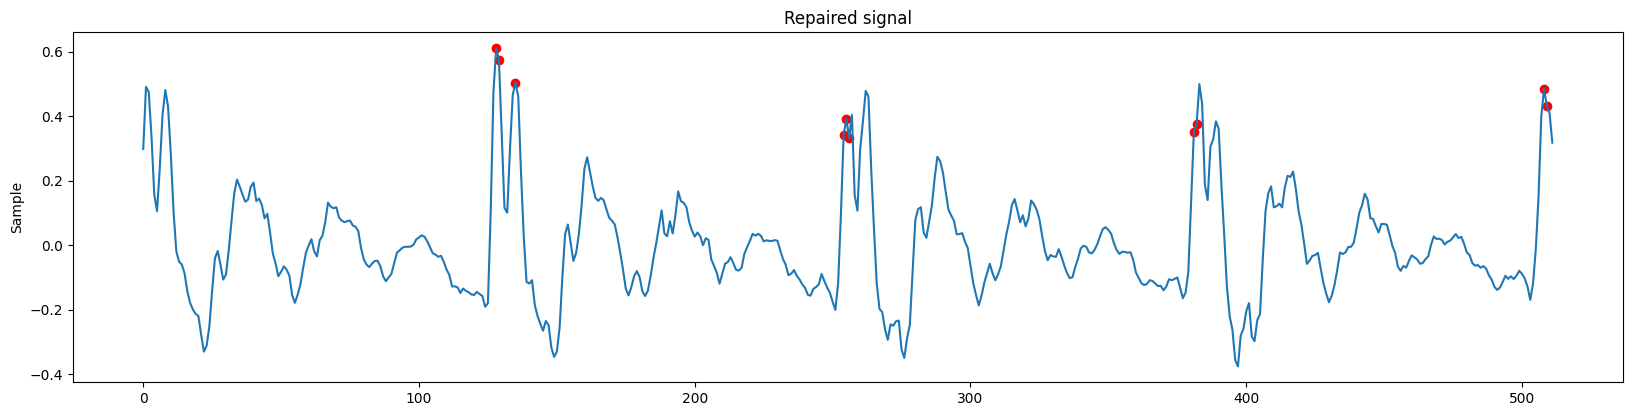

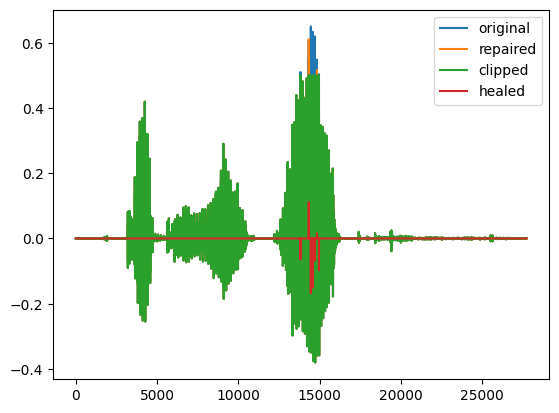

In [46]:
view_result(signals_combinedLPC[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_combinedLPC[0], rate=Fs)

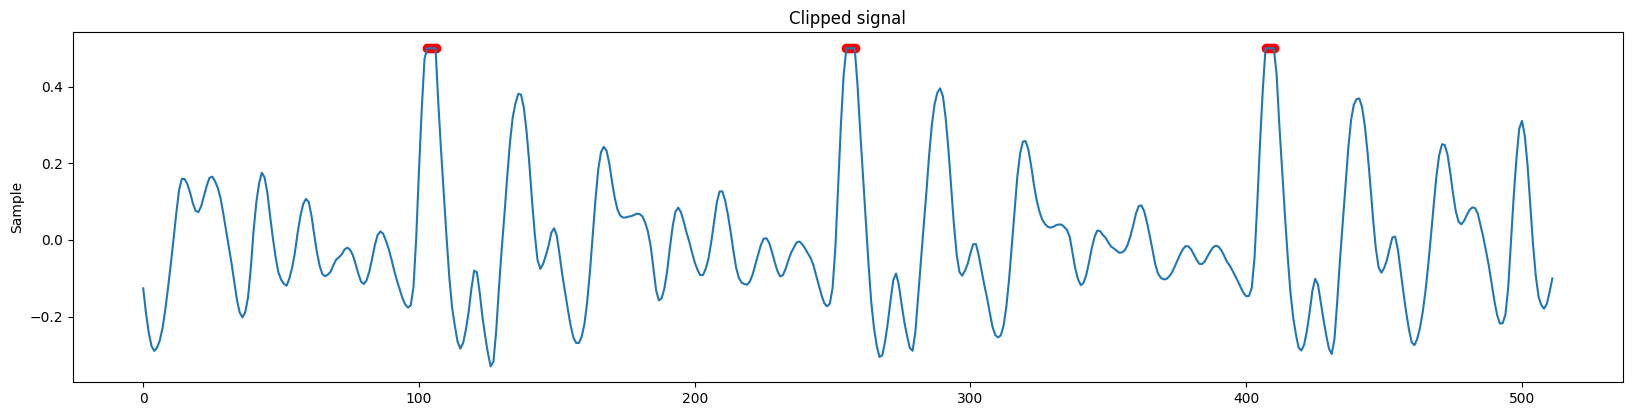

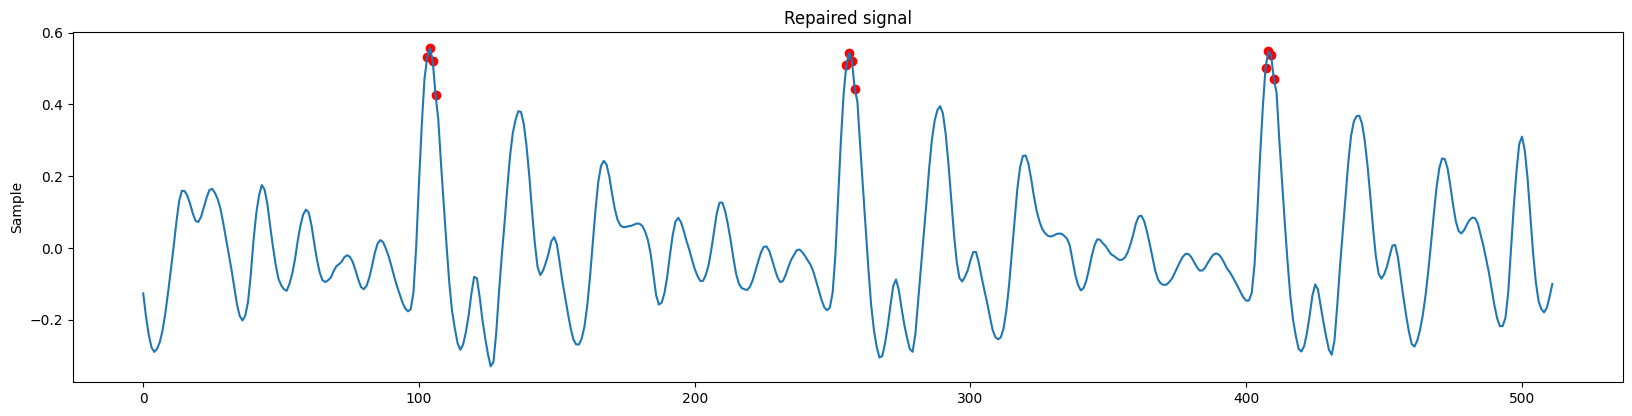

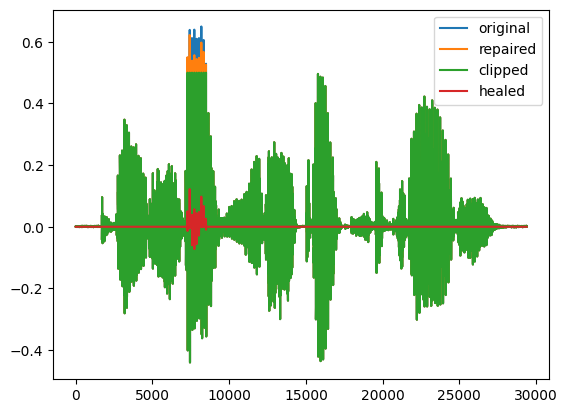

In [47]:
view_result(signals_combinedLPC[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_combinedLPC[1], rate=Fs)

## Úloha 6 - Cokoliv lepšího - ` 12 bodů`

Navrhněte a implementujte jakékoliv zlepšení rekonstrukce, možné příklady jsou: 

*   Optimalizace délky okna. 
*   Korektní práce s minulými či budoucími vzorky, pokud je za sebou více klipovaných částí (neměly by vstupovat do korelace pro výpočet R[k] a už vůbec ne do predikce vzorků)
*   Využití dynamické délky okna a dynamické délky prediktoru podle charakteru signálu. 
* Dlouhodobá predikce využívající základního tónu. 
* Analytické odvození, jak má predikce vzorků probíhat simultánně z levého či pravého kontextu nebo nalezení v literatuře a implementace. 
* Využití strojového učení (např. neuronová síť predikující vzorky)
* Cokoliv jiného  

Pro navrženou metodu proveďte opět ty samé kroky jako v minulých cvičeních, tedy vzorky k zobrazení a poslechu, a výpočet závislost SNR a SNRR. Komentujte výsledky. **Toto cvičení se bude obhajovat v pondělí 15. května**, nachystajte si prosím max. 10-minutovou presentaci - pár slajdů s popisem, co jste dělali, SNRR, ploty. 

---





### Vaše řešení:

Dále jsem se rozhodl vuyžít metodu `Consistent iterative hard thresholding`, která se snaží klipovaný signál reprezentovat pomocí omezeného počtu DCT složek (kosinusovek různých frekvencí). K nalezení nejlepší shody se využívá gradient descent metoda optimalizující funkci podobnosti ke klipovanému signálu.

In [64]:
def DCT_dictionary(frame_size=256, redundancy_factor=2):
    """
    DCT dictionary of shape (frame_size:frame_size*redundancy_factor)
    """
    m = frame_size * redundancy_factor
    t = np.arange(frame_size)
    f = np.arange(m)

    D = np.cos(np.pi/m * np.dot((t[np.newaxis, :].T+1/2), f[np.newaxis, :]+1/2))
    D = D/np.sqrt(np.sum(D**2,0)) # normalize columns
    return	D

def consistentIHT(signal, clipped_samples_mat, D, iters = 100, non_zero = 164):
    """
    Consistent iterative hard thresholding returns sparse activation matrix a
    """

    # initialize sparse coefficient matrix:
    a = np.zeros((D.shape[1]))
    # step constant
    mu = 1/np.linalg.norm(D,2)**2

    clipped_pos = np.logical_and(clipped_samples_mat, signal >= 0)
    clipped_neg = np.logical_and(clipped_samples_mat, signal <= 0)

    cost = np.zeros(iters)
    residual = signal
    cost[0] = np.sum(residual**2)

    for it in range(1,iters):
        # gradient descent step:
        a += mu * D.T@residual
        # hard thresholding:
        a *= abs(a) >= np.sort(np.abs(a),0)[a.shape[0]-non_zero]

        # compute residual:
        residual = signal - D @ a
        # enforce clipping consistency:
        residual[clipped_pos] = np.maximum(residual[clipped_pos],0)
        residual[clipped_neg] = np.minimum(residual[clipped_neg],0)

        # compute cost:
        cost[it] = np.sum(residual**2)
        if cost[it] < 1e-4:
            break

    return a, cost


def repair_clipped(signal,threshold=2):
    """
    Repair clipped samples using consistent iterative hard thresholding
    """
    clipped_samples = np.logical_or(signal<=-threshold,signal>=threshold)
    mask = np.ones(signal.shape)
    mask[clipped_samples] = 0
    if np.sum(clipped_samples) == 0:
        return signal
    a, _ = consistentIHT(signal,clipped_samples,D_DCT)
    sig_fix = D_DCT@a
    #apply mask to get rid of samples that were not clipped
    sig_fix2 = signal*mask + sig_fix*(1-mask)
    return sig_fix2

frame_length = 256
D_DCT = DCT_dictionary(frame_length)


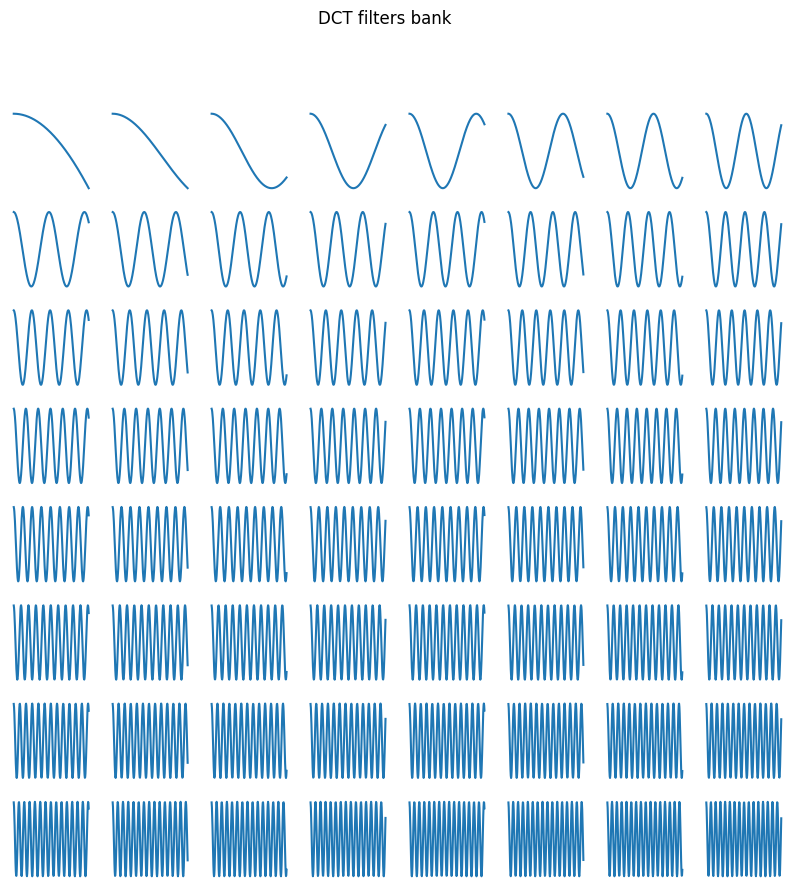

In [49]:
plt.figure(figsize=(10,10))
for i in range(0,64):
    plt.subplot(8,8,i+1)
    plt.plot(D_DCT[:,i])
    plt.axis('off')
plt.suptitle("DCT filters bank")
plt.show()

In [65]:
# repair clipped frames as whole
def repair_per_frame(signal, threshold):
    fixed = signal.copy()
    for i in range(0,signal.shape[0], frame_length):
        #cutoff
        if i+frame_length > signal.shape[0]:
            break
        fixed[i:i+frame_length] = repair_clipped(signal[i:i+frame_length],threshold)
    return fixed

signals_IHT = []
for i in range(0,len(signals_orig),sample_density):
    clp,orig = signals_clp[i], signals_orig[i]
    repr = repair_per_frame(clp,clipp_threshold)

    table.loc[i, ('IHT', 'foo')] = snr(orig,repr)
    if i in [show_example1, show_example2]:
        signals_IHT.append(repr)

#add snrr
table[('IHT'," snrr %")] = table[('IHT', 'foo')] / table[('clip', 'foo')] * 100
table

SS =  121.10147714614868
IHT sum 124.84179973602295
left sum 124.92925882339478
right sum 149.00484085083008


method  clip  left             right             combined             IHT   
P        foo     2    11    20     2    11    20        2   11   20   foo   
0      29.11 16.60 19.33 19.04 20.84 30.64 31.04      NaN  NaN  NaN 32.85  \
1      29.13   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
2      27.67   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
3      31.34   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
4      27.12   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
..       ...   ...   ...   ...   ...   ...   ...      ...  ...  ...   ...   
95     28.37   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
96     28.65   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
97     26.45   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
98     31.06   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   
99     29.57   NaN   NaN   NaN   NaN   NaN   NaN      NaN  NaN  NaN   NaN   

method     left                        right                         IHT  
P      2 snrr % 11 snrr % 20 snrr % 2 snrr % 11 snrr % 20 snrr %  snrr %  
0         57.03     66.39     65.40    71.60    105.27    106.62  112.85  
1           NaN       NaN       NaN      NaN       NaN       NaN     NaN  
2           NaN       NaN       NaN      NaN       NaN       NaN     NaN  
3           NaN       NaN       NaN      NaN       NaN       NaN     NaN  
4           NaN       NaN       NaN      NaN       NaN       NaN     NaN  
..          ...       ...       ...      ...       ...       ...     ...  
95          NaN       NaN       NaN      NaN       NaN       NaN     NaN  
96          NaN       NaN       NaN      NaN       NaN       NaN     NaN  
97          NaN       NaN       NaN      NaN       NaN       NaN     NaN  
98          NaN       NaN       NaN      NaN       NaN       NaN     NaN  
99          NaN       NaN       NaN      NaN       NaN       NaN     NaN  

[100 rows x 18 columns]

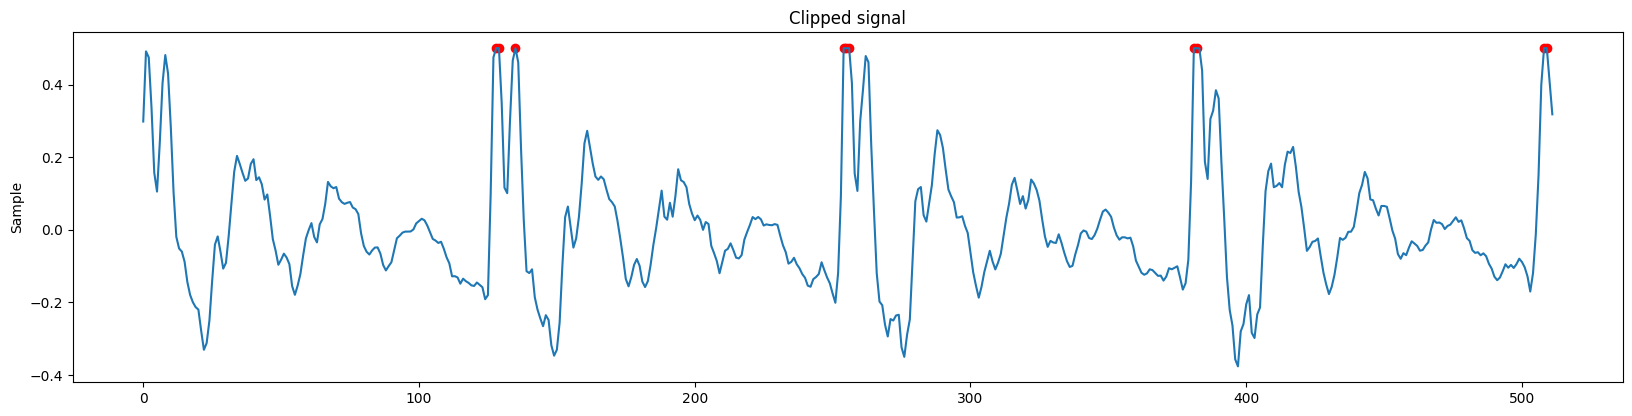

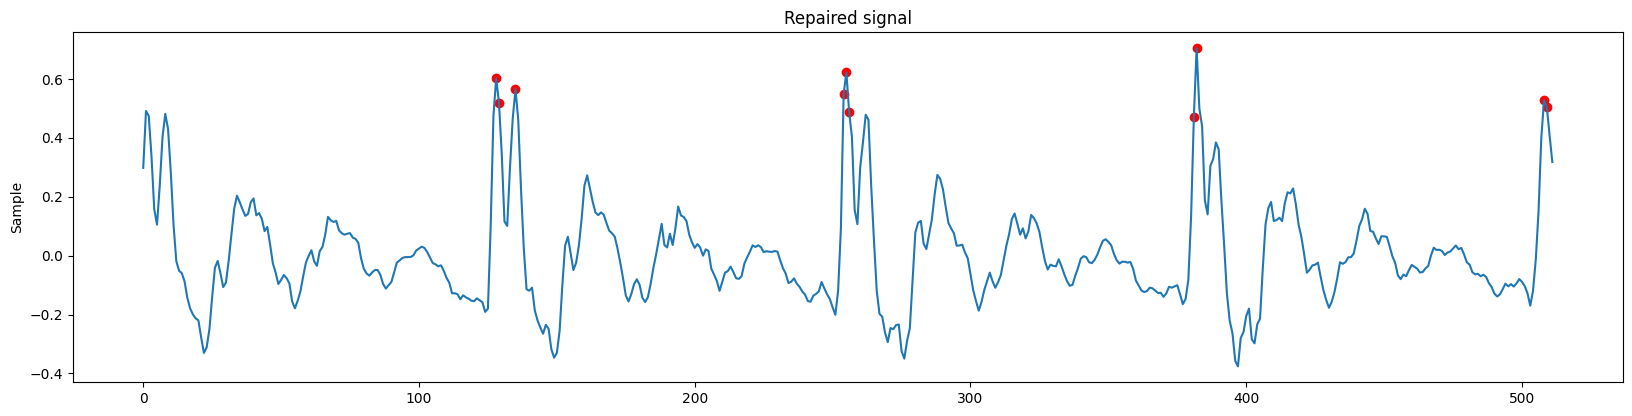

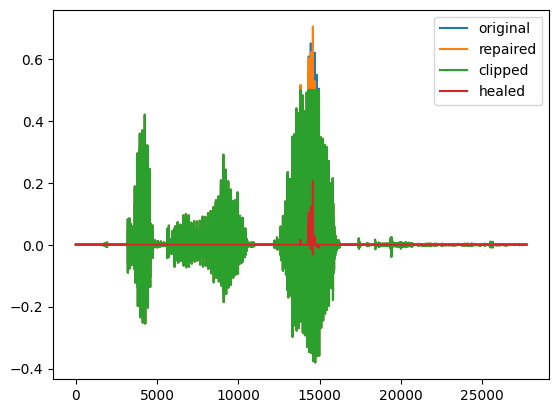

In [51]:
view_result(signals_IHT[0], signals_clp[show_example1], signals_orig[show_example1])
Audio(signals_IHT[0], rate=Fs)

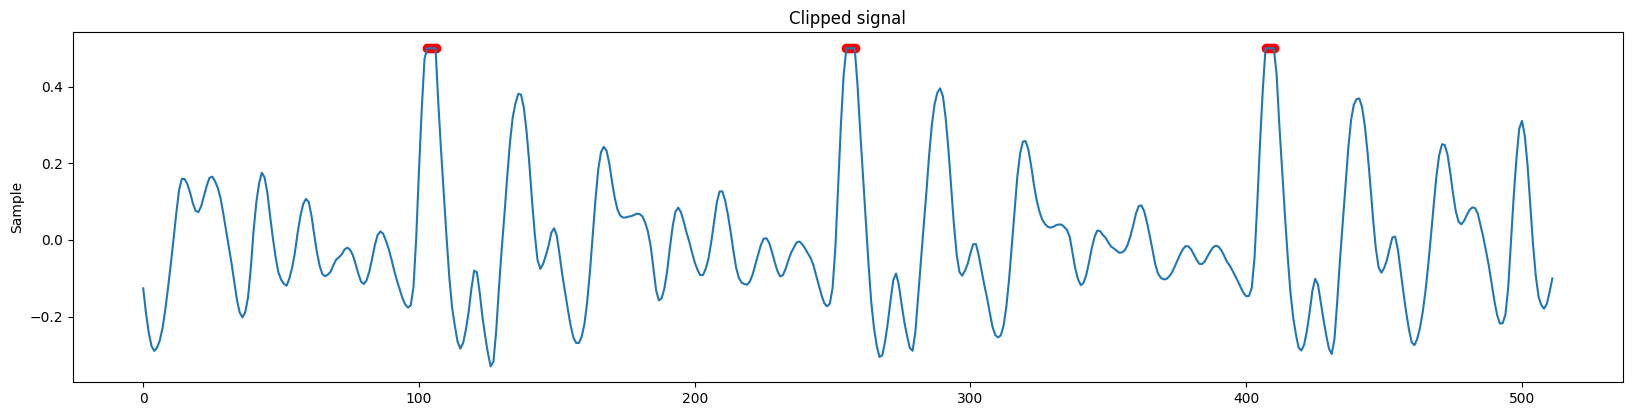

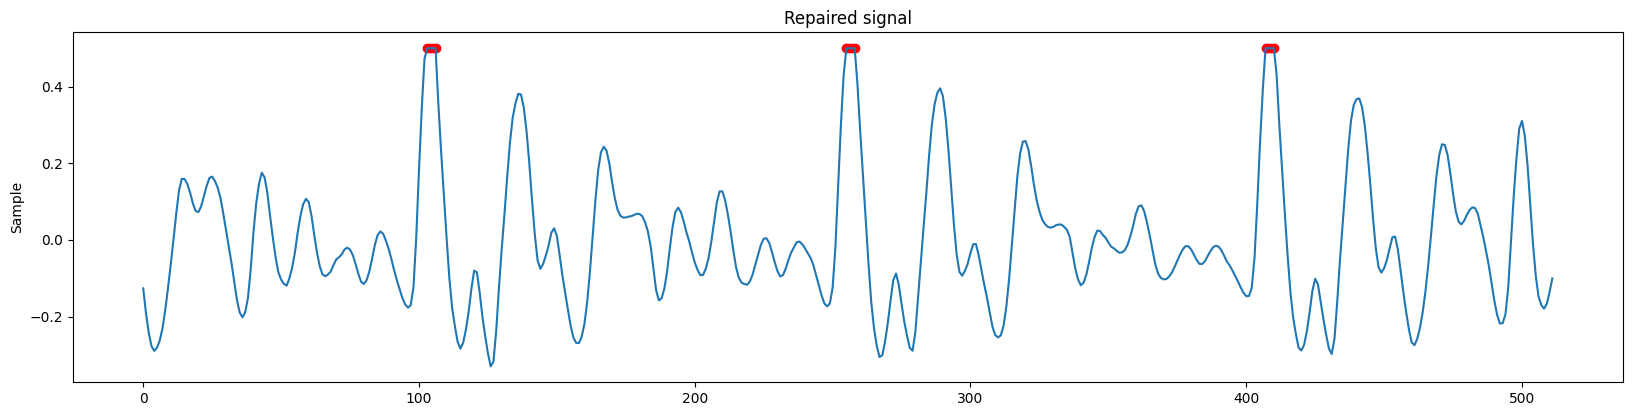

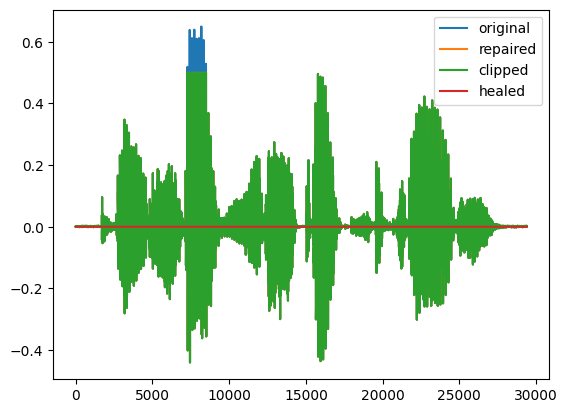

In [52]:
view_result(signals_IHT[1], signals_clp[show_example2], signals_orig[show_example2])
Audio(signals_IHT[1], rate=Fs)

# Hodnocení

Viz zadání. Jak je v ZRE zvykem, student/ka s nejinovativnějším / nejzajímavějším řešením dostane láhev dobrého červeného.